In [1]:
import  os, sys
import  jax
import  numpy as np
import  jax.numpy as jnp
import  matplotlib.pyplot as plt
from    pathlib import Path
# jax.config.update("jax_log_compiles", True)

# -----------------------------------------------------------------------
current_directory   = Path().resolve()
project_directory   = current_directory.parent.resolve()
print(f"Current directory: {current_directory}")
print(f"Project directory: {project_directory}")
sys.path.insert(0, str(project_directory))

# -----------------------------------------------------------------------
# Importer
# -----------------------------------------------------------------------

backend     = 'jax'
dtype       = jnp.complex128
dtypenet    = jnp.complex128
# dtypenet    = jnp.complex128
key_seed    = 1234
say_info    = False
save_path   = "./kitaev/"

from impurity_solver import (
    info, 
    quick_start, 
    logger,
    NQS,
    SolverType,
    PhysicsConfig, SolverConfig, make_hamiltonian, make_net,
    compute_both,
    compute_analytical_gs_energy,
    compute_ed_observables, compute_nqs_observables,
    compute_impurity_distances,
    NetworkFactory,
)

# Entropy tools
try:
    from QES.NQS.src.nqs_entropy import (
        compute_renyi_entropy,
        compute_ed_entanglement_entropy,
        compute_entropy_sweep,
        bipartition_cuts,
    )
    HAS_ENTROPY = True
except ImportError:
    HAS_ENTROPY = False
    print("Warning: nqs_entropy not available. Entropy computations disabled.")

# Equivariant GCNN (group-equivariant network)
try:
    from QES.general_python.ml.net_impl.networks.net_gcnn import EquivariantGCNN
    from QES.general_python.lattices.tools.lattice_symmetry import generate_space_group_perms
    HAS_EQGCNN = True
except ImportError:
    HAS_EQGCNN = False

# Print GPU memory info
print(f"\nJAX devices: {jax.devices()}")
print(f"JAX backend: {jax.default_backend()}")
print(f"Is GPU available: {jax.default_backend() == 'gpu'}")


Current directory: /Users/makskliczkowski/Codes/pyprojects/pyprojects-2025/kitaev/nqs/notebooks
Project directory: /Users/makskliczkowski/Codes/pyprojects/pyprojects-2025/kitaev/nqs
Using QES path: /Users/makskliczkowski/Codes/QuantumEigenSolver/pyqusolver/Python
-> Adding to sys.path - file_path: /Users/makskliczkowski/Codes/pyprojects/pyprojects-2025/kitaev/nqs/notebooks
-> Adding to sys.path - mod_path: /Users/makskliczkowski/Codes/pyprojects/pyprojects-2025/kitaev/nqs
-> Adding to sys.path - qes_path: /Users/makskliczkowski/Codes/QuantumEigenSolver/pyqusolver/Python
-> Adding to sys.path - lib_path: /Users/makskliczkowski/Codes/QuantumEigenSolver/pyqusolver/Python/QES
-> Adding to sys.path - gen_python: /Users/makskliczkowski/Codes/QuantumEigenSolver/pyqusolver/Python/QES/general_python
14_02_2026_01-17_30 [INFO] Switched active backend to JAX.

JAX devices: [CpuDevice(id=0)]
JAX backend: cpu
Is GPU available: False


In [2]:
impurities          =   [(1, np.pi, 0, 1.0),    (2, 0, 0, 1.0)] # add two impurities at sites 1 and 2 -> -1 at site 1 and +1 at site 2 (antiparallel)
impurities          =   [(1, 0.0, 0, 1.0),      (2, 0, 0, 1.0)] # add two impurities at sites 1 and 2 -> -1 at site 1 and +1 at site 2 (antiparallel)
impurities          =   [(1, 0.0, 0, 1.0)]                      # add single impurity at site 1 -> +1 at site 1 (z-polarized)
impurities          =   [(1, np.pi, 0, 1.0)]                    # add single impurity at site 1 -> -1 at site 1 (z-polarized)
impurities          =   [(2, np.pi, 0, 1.0)]                    # add single impurity at site 2 -> -1 at site 2 (z-polarized) 
impurities          =   [(2, 0, 0, 1.0)]                        # add single impurity at site 2 -> +1 at site 2 (z-polarized)
p_cfg               =   PhysicsConfig(
                            model_type      =   'kitaev',
                            lattice_type    =   'honeycomb',
                            lx              =   4,
                            ly              =   3,
                            kxy             =   0.0,
                            kz              =   0.0,
                            gamma_xy        =   1.0,
                            gamma_z         =   1.0,
                            hx              =   None,
                            hy              =   None,
                            bc              =   'pbc',
                            # impurities      =   impurities
                        )
# Example:    [(0, 0, np.pi/2, 1.0)]          adds x-polarized impurity at site 0.
#             [(0, np.pi/2, np.pi/2, 1.0)]    adds y-polarized impurity at site 0.
#             [(0, 0, 0, 1.0)]                adds z-polarized impurity at site 0.
#             [(0, theta, phi, strength), ...]
# (site_index, theta, phi, strength)) - spherical coordinates for impurity spin direction -> S=(sin(theta)cos(phi), sin(theta)sin(phi), cos(theta)) * strength

has_impurities          = (p_cfg.impurities is not None and len(p_cfg.impurities) > 0) or True
hamil, hilbert, lattice = make_hamiltonian(p_cfg, dtype=dtype, tx=0 if not has_impurities else None, ty=0 if not has_impurities else None, verbose=True)
hamil

14_02_2026_01-17_31 [INFO] 	->[Hamiltonian] Using provided HilbertSpace: ns=24, lattice=yes


14_02_2026_01-17_31 [INFO] 	->[Hamiltonian] Hamiltonian basis inherited from HilbertSpace: real
14_02_2026_01-17_31 [INFO] 		->[Hamiltonian] Default basis inferred: real (unknown)
14_02_2026_01-17_31 [INFO] 	->[Hamiltonian] Initializing Heisenberg-Kitaev Hamiltonian on lattice: HON,pbc,d=2,Ns=24,Lx=4,Ly=3,Lz=1
14_02_2026_01-17_31 [INFO] 		->[Hamiltonian] Impurities provided: []
14_02_2026_01-17_31 [INFO] 			->[Kitaev-Heisenberg-Gamma Model] Total NN elements added: 72
14_02_2026_01-17_31 [INFO] 	->[Kitaev-Heisenberg-Gamma Model] Successfully set local energy operators...
14_02_2026_01-17_41 [INFO] 			->[Kitaev-Heisenberg-Gamma Model] Composition function compiled in 9.808025 seconds.


Kitaev(Ns=24,Kx=0.000,Ky=0.000,Kz=0.000,Gx=1.000,Gy=1.000,Gz=1.000,dlt=1.000)

i:  0 , nei:  17 , bond:  x
i:  0 , nei:  1 , bond:  y
i:  0 , nei:  7 , bond:  z
i:  1 , nei:  8 , bond:  x
i:  1 , nei:  0 , bond:  y
i:  1 , nei:  2 , bond:  z
i:  2 , nei:  19 , bond:  x
i:  2 , nei:  3 , bond:  y
i:  2 , nei:  1 , bond:  z
i:  3 , nei:  10 , bond:  x
i:  3 , nei:  2 , bond:  y
i:  3 , nei:  4 , bond:  z
i:  4 , nei:  21 , bond:  x
i:  4 , nei:  5 , bond:  y
i:  4 , nei:  3 , bond:  z
i:  5 , nei:  12 , bond:  x
i:  5 , nei:  4 , bond:  y
i:  5 , nei:  6 , bond:  z
i:  6 , nei:  23 , bond:  x
i:  6 , nei:  7 , bond:  y
i:  6 , nei:  5 , bond:  z
i:  7 , nei:  14 , bond:  x
i:  7 , nei:  6 , bond:  y
i:  7 , nei:  0 , bond:  z
i:  8 , nei:  1 , bond:  x
i:  8 , nei:  9 , bond:  y
i:  8 , nei:  15 , bond:  z
i:  9 , nei:  16 , bond:  x
i:  9 , nei:  8 , bond:  y
i:  9 , nei:  10 , bond:  z
i:  10 , nei:  3 , bond:  x
i:  10 , nei:  11 , bond:  y
i:  10 , nei:  9 , bond:  z
i:  11 , nei:  18 , bond:  x
i:  11 , nei:  10 , bond:  y
i:  11 , nei:  12 , bond:  z
i:  12 ,

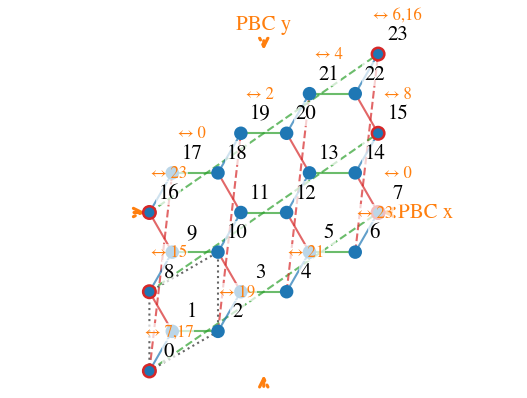

In [3]:
fig, ax = lattice.plot_structure(show_indices=True)
map_bond = lambda x: {0:'x', 1:'y', 2:'z'}.get(x, 'cut')
for i in range(lattice.ns):
    nn_i = lattice.nn[i]
    for nei in nn_i:
        print("i: ", i, ", nei: ", nei, ", bond: ", map_bond(lattice.bond_type(i, nei)))
    


In [4]:
lattice.get_region(kind='half_x', origin=11, radius=1)

[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19]

## 1. Configure the NQS with VMC Sampler

In [ ]:
perf_exact_diag =   True
perf_exact_diag =   perf_exact_diag and (lattice.ns <= 20)

# Solver config (controls SOTA parameter estimation)
s_cfg           =   SolverConfig(ansatz='rbm', dtype='complex128')

# Choose network type — make_net uses estimate_network_params() under the hood
# Options: 'rbm', 'cnn', 'resnet', 'ar', 'pp', 'rbmpp', 'eqgcnn'
# User overrides via **kwargs (passed through to estimate_network_params):
#   RBM:    alpha=<float>           (hidden-unit density, default 4 for Kitaev)
#   CNN:    n_layers, base_feat, activation
#   ResNet: base_features, base_depth, kernel_size
#   AR:     base_hidden, n_layers
#   EqGCNN: n_layers, base_channels
net_type        =   'rbm'
# net_type        =   'cnn'
# net_type        =   'resnet'

net             =   make_net(net_type, p_cfg=p_cfg, s_cfg=s_cfg, dtype=dtype)
# Example with user override: make_net('rbm', p_cfg=p_cfg, s_cfg=s_cfg, dtype=dtype, alpha=6.0)
net

12_02_2026_11-36_30 [INFO] 	->SOTA config for rbm: RBM with a=8.0 (144 hidden units). Complex params capture sign structure of kitaev model. 


ComplexRBM(shape=(18,), hidden=144, bias=on, visible_bias=on, dtype=complex128, params=2754, analytic_grad=False, initialized)

In [ ]:
sample_config   = NQS.get_auto_config(system_size=hilbert.ns, logger=logger, dtype=dtype, target_total_samples=5e3, net_depth_estimate=net._param_num, num_therm=10, num_sweep=10)
psi             = NQS(
                    logansatz       =   net,
                    model           =   hamil,
                    backend         =   backend,
                    shape           =   (hilbert.ns,),
                    dtype           =   dtype,
                    directory       =   save_path,
                    replica         =   1,              # Number of replicas for parallel sampling
                    **sample_config,                    # Sampling configuration
                    # other
                    logger          =   logger,
                    seed            =   key_seed,
                )
if say_info:    psi.help('train')
if say_info:    info()
if say_info:    quick_start()
use_minsr       = psi.num_params > psi.sampler.numsamples * psi.sampler.numchains * 1000

12_02_2026_11-36_33 [INFO] 	->Auto-detected backend: GPU (NVIDIA GeForce RTX 4060)
12_02_2026_11-36_33 [INFO] 		->WARNING: Double precision (complex128) detected on GPU.
12_02_2026_11-36_33 [INFO] 		->Detected GPU: NVIDIA GeForce RTX 4060 with 8188 MB VRAM (39 MB free).
12_02_2026_11-36_33 [INFO] 	->Optimized: 256 Parallel Chains x 19 Samples
12_02_2026_11-36_33 [INFO] 		->Total VMC Batch Size: 4864 samples per evaluation.
12_02_2026_11-36_33 [INFO] 	->Initializing NQS network backend: JAX
12_02_2026_11-36_33 [INFO] 		->Network is holomorphic: True
12_02_2026_11-36_33 [INFO] 		->Network has analytic gradient: False
12_02_2026_11-36_33 [WARNING] Using MCSampler:
  - State shape: (18,) (Size: 18)
  - Backend: jax
  - Chains: 256, Samples/Chain: 19
  - Params: mu=2.000, beta=1.000, logprob_fact=0.500
  - Update Rule: LOCAL (Default) (Steps/Update: 1)
  - Global Updates: none (p=0.00)
  - Initial State: RND
  - Replicas (PT): 1
  - Thermalization: 10 sweeps x 10 steps/sweep (32400 total si

In [6]:
%timeit psi.sample()[1][0]
# %timeit psi.sample()[1][0]|

568 ms ± 956 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# Optionally perform exact diagonalization BEFORE training (to store in stats)
if perf_exact_diag:
    paths       = [str(psi.defdirpar / 'ed_dataset.h5'), psi.defdir / 'stats.h5']
    perfexact   = False
    for p in paths:
        if os.path.exists(p) and psi.exact is None:
            perfexact = False
            try:
                psi.load_exact(p, key='exact/predictions' if 'stats.h5' in p else 'energy_values')
            except:
                perfexact = True
        elif psi.exact is None:
            perfexact = True
    if perfexact:
        psi.get_exact(verbose=True)

train_config = {
    'load_checkpoint'       :   False,
    'reset_weights'         :   True,
    'checkpoint_step'       :   None,
    'n_epochs'              :   3000,
    'checkpoint_every'      :   500,
    'n_batch'               :   128,
    'n_update'              :   1,
    # x-bond only flips
    # 'upd_fun'               :   'worm',
    # local flips
    'upd_fun'               :   'local',
    # bond flips
    # 'upd_fun'               :   'bond',
    # plaquette flips
    # 'upd_fun'               :   'plaquette',
    # exchange flips
    # 'upd_fun'               :   'exchange',

    # global flips
    # 'global_p'              :   0.02,
    # 'global_update'         :   'wilson',
    # 'global_fraction'       :   0.2,
    # sampler
    'num_samples'           :   None,               # infer from auto config
    'num_chains'            :   None,               # infer from auto config
    # other configs
    'reset_stats'           :   False,
    'use_pbar'              :   True,
    # 'lin_solver'            :   'minsr'             if use_minsr else 'minres_qlp',
    'lin_solver'            :   'minres_qlp',
    'lin_force_mat'         :   use_minsr,
    'ode_solver'            :   'Euler',
    'pre_solver'            :   'jacobi'            if use_minsr else None,
    # Learning rate scheduler
    'lr'                    :   1e-2                if not use_minsr else 1e-2,
    'lr_scheduler'          :   'cosine',
    'lr_final'              :   1e-4,
    'early_stopper'         :   None,
    # Diagonal shift (SR regularization)
    'diag_scheduler'        :   'cosine',
    'diag_shift'            :   8e-3                if not use_minsr else 1e-1,
    'diag_final'            :   1e-3,
    # SR config
    'use_minsr'             :   use_minsr,
    'use_sr'                :   True,
    # Gradient clipping: prevents explosion from occasional bad samples
    # 'grad_clip'             :   1e2,
    # Exact reference for comparison
    'exact_predictions'     :   psi.exact['exact_predictions'] if psi.exact is not None else hamil.eig_val,
    'use_timing'            :   True,
    'timing_mode'           :   'detailed',
    'symmetrize'            :   True
}

# Train or load checkpoint safely
stats = psi.train(**train_config)

12_02_2026_11-36_53 [INFO] 	->[Kitaev-Heisenberg-Gamma Model] Diagonalization started using method='lanczos'...
12_02_2026_11-36_53 [INFO] 		->[Kitaev-Heisenberg-Gamma Model] Computing 6 eigenvalues
12_02_2026_11-36_53 [INFO] 		->[Kitaev-Heisenberg-Gamma Model] Backend: jax
12_02_2026_11-40_10 [INFO] 		->Diagonalization completed using lanczos
12_02_2026_11-40_10 [INFO] 		->Computed 6 eigenvalues
12_02_2026_11-40_10 [INFO] 		->Converged in 200 iterations
12_02_2026_11-40_11 [INFO] 		->[Kitaev-Heisenberg-Gamma Model] Diagonalization (lanczos) completed in 197.436434 seconds, 0.054843 hours.
12_02_2026_11-40_11 [INFO] 	->Exact information set: -22.55248584322804
12_02_2026_11-40_11 [INFO] 	->Exact ground state energy: -22.552486
12_02_2026_11-40_11 [INFO] 	->Initializing Orbax CheckpointManager.
12_02_2026_11-40_11 [INFO] 		->Checkpoints (max 3) will be saved to: /home/klimak/Codes/pyprojects/pyprojects-2025/kitaev/nqs/notebooks/kitaev/Kitaev(Ns=18,Kx=0.000,Ky=0.000,Kz=0.000,Gx=1.000,Gy=

NQS Training:   0%|          | 0/3000 [00:00<?, ?it/s]

12_02_2026_11-40_13 [INFO] 	->Sampled 4864 configurations with batch size 128
12_02_2026_11-40_13 [INFO] 	->Prepared lower states for excited state handling
12_02_2026_11-40_13 [INFO] 		->TDVP Solve Timings: TDVPTimes(prepare=0.001751522, gradient=0.001196676, covariance=0.0, x0=0.000904856, solve=0.031421104, phase=0.0)
12_02_2026_11-52_26 [INFO] 	->Saved Orbax checkpoint for step 500
12_02_2026_11-52_26 [INFO] 	->Saved weights for step 500 to /home/klimak/Codes/pyprojects/pyprojects-2025/kitaev/nqs/notebooks/kitaev/Kitaev(Ns=18,Kx=0.000,Ky=0.000,Kz=0.000,Gx=1.000,Gy=1.000,Gz=1.000,dlt=1.000)/HON,obc,d=2,Ns=18,Lx=3,Ly=3,Lz=1/ComplexRBM(shape=(18,),hidden=144,dtype=complex128)/checkpoints/500
12_02_2026_12-06_30 [INFO] 	->Saved Orbax checkpoint for step 1000
12_02_2026_12-06_30 [INFO] 	->Saved weights for step 1000 to /home/klimak/Codes/pyprojects/pyprojects-2025/kitaev/nqs/notebooks/kitaev/Kitaev(Ns=18,Kx=0.000,Ky=0.000,Kz=0.000,Gx=1.000,Gy=1.000,Gz=1.000,dlt=1.000)/HON,obc,d=2,Ns=18,

In [8]:
hamil.eig_val

array([-22.55248584, -22.19011535, -22.19011535, -22.12295534,
       -21.85253898, -21.8444604 ])

12_02_2026_14-00_37 [INFO] Exact ground state energy: -22.552486
12_02_2026_14-00_37 [INFO] 		->Lowest energies: [-22.55248584 -22.19011535 -22.19011535 -22.12295534 -21.85253898]
12_02_2026_14-00_37 [INFO] NQS estimated energy: -22.352683
12_02_2026_14-00_37 [INFO] 		->Relative error: 0.8969%
12_02_2026_14-00_37 [INFO] 		->Total error: 1.1237e-02
Final energy estimate: -2.483772 ± 0.001281


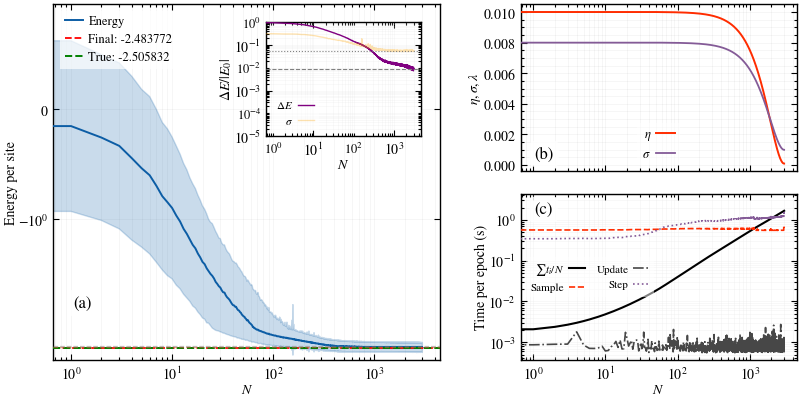

<Figure size 525x393.75 with 0 Axes>

In [12]:
if not stats.has_exact:
    stats_ed = psi.get_exact()
else:
    stats_ed = stats

# Report final comparison
if stats_ed.has_exact:
    logger.info(f"Exact ground state energy: {stats.exact_gs:.6f}")
    if len(stats_ed.exact_predictions) > 1:
        logger.info(f"Lowest energies: {stats_ed.exact_predictions[:5]}", lvl=2, color='green')
    logger.info(f"NQS estimated energy: {stats_ed.history[-1]:.6f}")
    logger.info(f"Relative error: {psi.relative_error(stats.history, stats.exact_gs, last_el = 0.05) * 100:.4f}%", lvl=2, color='green')
    logger.info(f"Total error: {(psi.est(stats.history, last_el = 0.05) - stats.exact_gs) / lattice.ns:.4e}", lvl=2, color='purple')

# Get exact energies from stats (if available) or Hamiltonian
if stats_ed.has_exact:
    ed_energy           = stats_ed.exact_gs                 / lattice.lxly
    ed_excited_energies = stats_ed.exact_predictions[1:11]  / lattice.lxly if len(stats_ed.exact_predictions) > 1 else np.array([])
elif hamil.eigenvalues is not None:
    ed_energy           = hamil.eigenvalues[0]              / lattice.lxly
    ed_excited_energies = hamil.eigenvalues[1:11]           / lattice.lxly
else:
    ed_energy           = None
    ed_excited_energies = np.array([])

history                 = np.array(stats.history)           / lattice.lxly
history_std             = np.array(stats.history_std)       / lattice.lxly
last_energies           = history[-30:] 
last_energy             = np.mean(last_energies)
last_energy_std         = np.std(last_energies)
print(f"Final energy estimate: {last_energy:.6f} ± {last_energy_std:.6f}")

# ---------------------------------------------------------
# Layout
# ---------------------------------------------------------

from QES.general_python.common.plot import Plotter

fig         = plt.figure(figsize=(8, 4), dpi=100)
gs          = Plotter.get_grid(nrows=2, ncols=2, width_ratios=[1.4, 1], hspace=0.05, wspace=0.05, figure=fig)
ax0         = fig.add_subplot(gs[:, 0])   # Energy (full height)
ax1         = fig.add_subplot(gs[0, 1], sharex=ax0)
ax2         = fig.add_subplot(gs[1, 1], sharex=ax0)
x           = np.arange(len(history))
# ---------------------------------------------------------
# Energy Panel
# ---------------------------------------------------------

Plotter.plot(ax0, x=x, y=history, label='Energy', color='C0', lw=1.4)
Plotter.hline(ax0, last_energy, color='red', linestyle=':', lw=1.3, label=f'Final: {last_energy:.6f}')
Plotter.fill_between(ax0, x=x, y1=history - history_std, y2=history + history_std, color='C0', alpha=0.22)

# Exact & excited references
if ed_energy is not None:
    Plotter.hline(ax0, ed_energy, color='green', linestyle='--', lw=1.4, label=f'True: {ed_energy:.6f}')
    for i, ene in enumerate(ed_excited_energies):
        Plotter.hline(ax0, ene, color=f'C{i+2}', ls='--', alpha=0.25, lw=0.9)

Plotter.set_ax_params(ax0, xlabel='$N$', ylabel='Energy per site' , xscale='log', yscale='symlog')
Plotter.set_legend(ax0, fontsize=9, frameon=True, loc='upper left', framealpha=0.7, markerfirst=True)
Plotter.set_tickparams(ax0)
Plotter.grid(ax0, which='both', alpha=0.1, color='gray')
Plotter.set_annotate_letter(ax0, iter=0, x=0.05, y=0.15)

# ---------------------------------------------------------
# Inset: absolute error (log scale)
# ---------------------------------------------------------

if ed_energy is not None:
    abs_err = np.abs(history - ed_energy) / np.abs(ed_energy) + 1e-14
    inset   = ax0.inset_axes(bounds=[0.55, 0.63, 0.4, 0.32])
    x_inset = np.arange(len(abs_err))
    y       = abs_err
    av      = np.mean(y[-50:])
    Plotter.plot(inset, x=x_inset, y=y, color='purple', lw=1.0, label=r'$\Delta E$')
    Plotter.hline(inset, val=av, color='gray', ls='--', lw=0.8)
    
    y       = history_std / np.abs(ed_energy) + 1e-14
    av      = np.mean(y[-50:])
    Plotter.plot(inset, x=x_inset, y=y, color='orange', lw=1.0, alpha=0.3,  label=r'$\sigma$')
    Plotter.hline(inset, val=av, color='gray', ls=':', lw=0.8)
    
    Plotter.set_ax_params(inset, xlabel=r"$N$", ylabel=r"$\Delta E / |E_0|$", yscale='log', xscale='log', ylim=(1e-5, 1e0))
    Plotter.set_legend(inset, fontsize=8, frameon=True, loc='lower left', framealpha=0.5)
    Plotter.set_tickparams(inset)
    Plotter.grid(inset, alpha=0.25, which='both')

# ---------------------------------------------------------
# Regularization Panel
# ---------------------------------------------------------

if len(stats.lr_history):
    Plotter.semilogy(ax1, x=np.arange(len(stats.lr_history)), y=stats.lr_history,       lw=1.4, label=r'$\eta$',    color='C3')
if len(stats.diag_history):
    Plotter.semilogy(ax1, x=np.arange(len(stats.diag_history)), y=stats.diag_history,   lw=1.3, label=r'$\sigma$',  color='C4')
if len(stats.reg_history):
    Plotter.semilogy(ax1, x=np.arange(len(stats.reg_history)), y=stats.reg_history,     lw=1.3, label=r'$\lambda$', color='C5')
    
Plotter.set_ax_params(ax1, ylabel=r'$\eta, \sigma, \lambda$', xscale='log')
Plotter.set_legend(ax1, fontsize=9, frameon=True, loc='lower center', framealpha=0.5)
Plotter.set_tickparams(ax1)
Plotter.grid(ax1, which='both', alpha=0.1, color='gray')
Plotter.set_annotate_letter(ax1, iter=1, x=0.05, y=0.08)

# Hide repeated x-ticks
plt.setp(ax1.get_xticklabels(), visible=False)

# ---------------------------------------------------------
# Timing Panel
# ---------------------------------------------------------

t_avg   = np.array(stats.timings.total) / len(stats.history)
x       = np.arange(len(t_avg))
Plotter.semilogy(ax2, x=x, y=t_avg, lw=1.5, label=r'$\sum t_i / N$')
Plotter.semilogy(ax2, x=x, y=stats.timings.sample[:len(x)], color='C3', ls='--', lw=1.2, label='Sample')
Plotter.semilogy(ax2, x=x, y=stats.timings.update[:len(x)], color='C5', ls='-.', lw=1.2, label='Update')
Plotter.semilogy(ax2, x=x, y=stats.timings.step[:len(x)],   color='C4', ls=':',  lw=1.2, label='Step')
Plotter.set_legend(ax2, frameon=True, loc='center left', ncols=2, framealpha=0.5, fontsize=8)
Plotter.set_ax_params(ax2, ylabel='Time per epoch (s)', xlabel=r'$N$', xscale='log', yscale='log')
Plotter.set_tickparams(ax2)
Plotter.grid(ax2, alpha=0.28, which='both')
Plotter.set_annotate_letter(ax2, iter=2, x=0.05, y=0.88)

# ---------------------------------------------------------
# Final layout
# ---------------------------------------------------------

plt.show()
plt.savefig(psi.defdir / 'training_summary.png', dpi=300)
# plt.tight_layout()

### a) Test the loss function computation

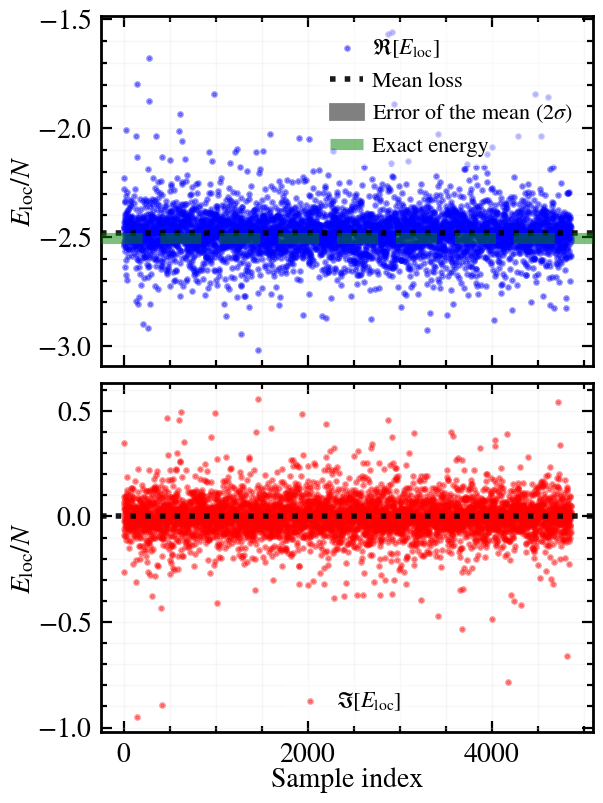

In [10]:
loss    = psi.compute_loss(return_stats=True)
fig, ax = Plotter.get_subplots(nrows=2, ncols=1, figsize=(3,4), dpi=200, sharex=True)
# Local loss per sample
if True:
    Plotter.scatter(ax[0], x=np.arange(len(loss.local_loss)), y=np.real(loss.local_loss) / lattice.lxly, s=2, color='blue', alpha=0.4, label=r'$\Re{[E_{\rm loc}]}$')
    Plotter.scatter(ax[1], x=np.arange(len(loss.local_loss)), y=np.imag(loss.local_loss) / lattice.lxly, s=2, color='red',  alpha=0.4, label=r'$\Im{[E_{\rm loc}]}$')
    Plotter.hline(ax[0], np.real(loss.mean_loss) / lattice.lxly, color='black', ls=':', alpha=0.9, label='Mean loss')
    Plotter.hline(ax[1], 0, color='black', ls=':', alpha=0.9)
    
    # Plotter.fill_between(
    #     ax              =   ax[0],
    #     x               =   np.arange(len(loss.local_loss)),
    #     y1              =   (np.real(loss.mean_loss) - np.real(loss.std_loss)) / lattice.lxly,
    #     y2              =   (np.real(loss.mean_loss) + np.real(loss.std_loss)) / lattice.lxly,
    #     color           =   'gray',
    #     alpha           =   1.0
    # )
    Plotter.fill_between(
        ax              =   ax[0],
        x               =   np.arange(len(loss.local_loss)),
        y1              =   (np.real(loss.mean_loss) - 2*np.real(loss.error_of_mean)) / lattice.lxly,
        y2              =   (np.real(loss.mean_loss) + 2*np.real(loss.error_of_mean)) / lattice.lxly,
        color           =   'gray',
        alpha           =   1.0,
        label           =   r'Error of the mean ($2\sigma$)',
    )
    
# ED
if psi.exact is not None:
    Plotter.hline(ax[0], psi.exact['exact_energy'] / (lattice.lxly), color='green', ls='--', lw=4, alpha=0.5, label='Exact energy')
    
Plotter.set_ax_params(ax[0], ylabel=r'$E_{\rm loc} / N$', yscale='linear')
Plotter.set_ax_params(ax[1], xlabel=r'Sample index', ylabel=r'$E_{\rm loc} / N$', yscale='linear')

for axis in ax:
    Plotter.set_tickparams(axis)
    Plotter.grid(axis, alpha=0.28, which='both')
    Plotter.set_legend(axis, fontsize=8, frameon=True, loc='best', framealpha=0.5, markerfirst=True)

### b) Correlation functions and plaquette operators

In [13]:
out = compute_both(psi, history=stats, log_progress=True)

KeyboardInterrupt: 

### c) Entanglement entropy (ED vs NQS)

Test the entanglement entropy calculation using **exact diagonalization** (SVD on eigenvectors)
and the **NQS replica method**. We sweep over all standard bipartition cuts on the honeycomb lattice:
`half_x`, `half_y`, `quarter`, `sublattice_A`.

In [ ]:
# -----------------------------------------------------------------------
# Entanglement entropy: ED (exact SVD) vs NQS (replica trick)
# -----------------------------------------------------------------------
if HAS_ENTROPY:
    q_values = [2, 3]  # Rényi indices

    # --- 1. Bipartition cuts on honeycomb ---
    cuts = bipartition_cuts(lattice, cut_type="all")
    print(f"Bipartition cuts ({len(cuts)} total):")
    for label, region in cuts.items():
        print(f"  {label:15s}: {len(region):3d} sites  →  {sorted(region)[:8]}{'...' if len(region) > 8 else ''}")

    # --- 2. ED entanglement entropy (ground state + first excited) ---
    ed_entropy = {}
    if perf_exact_diag and hamil.eig_vec is not None:
        n_states = min(3, hamil.eig_vec.shape[1])
        for label, region in cuts.items():
            if len(region) == 0 or len(region) >= lattice.ns:
                continue
            ee = compute_ed_entanglement_entropy(
                hamil.eig_vec, region, lattice.ns,
                q_values=q_values, n_states=n_states, method="svd",
            )
            ed_entropy[label] = ee
            vn = ee["von_neumann"][0]
            r2 = ee.get("renyi_2", [None])[0]
            print(f"  ED  {label:15s}: S_vN={vn:.6f}, S_2={r2:.6f}")
    else:
        print("  ED eigenvectors not available — skipping ED entropy.")

    # --- 3. NQS entanglement entropy (replica method, q=2,3) ---
    nqs_entropy = {}
    n_entropy_samples = 4096
    for label, region in cuts.items():
        if len(region) == 0 or len(region) >= lattice.ns:
            continue
        entry = {}
        for q in q_values:
            sq, sq_err = compute_renyi_entropy(
                psi, region=region, q=q,
                num_samples=n_entropy_samples,
                num_chains=s_cfg.n_chains,
                return_error=True,
            )
            entry[f"renyi_{q}"]     = float(sq)
            entry[f"renyi_{q}_err"] = float(sq_err)
            print(f"  NQS {label:15s}: S_{q}={sq:.6f} ± {sq_err:.6f}")
        entry["region_size"] = len(region)
        nqs_entropy[label] = entry

    # --- 4. Comparison plot: ED vs NQS ---
    labels_common = [l for l in cuts if l in ed_entropy and l in nqs_entropy]
    if labels_common:
        fig, axes = plt.subplots(1, len(q_values), figsize=(5 * len(q_values), 4), squeeze=False)
        for qi, q in enumerate(q_values):
            ax = axes[0, qi]
            x_pos       = np.arange(len(labels_common))
            ed_vals     = [ed_entropy[l].get(f"renyi_{q}", [np.nan])[0] for l in labels_common]
            nqs_vals    = [nqs_entropy[l].get(f"renyi_{q}", np.nan) for l in labels_common]
            nqs_errs    = [nqs_entropy[l].get(f"renyi_{q}_err", 0) for l in labels_common]

            ax.bar(x_pos - 0.15, ed_vals, width=0.3, label="ED (SVD)", color="steelblue", alpha=0.8)
            ax.bar(x_pos + 0.15, nqs_vals, width=0.3, label="NQS (replica)", color="coral", alpha=0.8,
                   yerr=nqs_errs, capsize=3)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(labels_common, rotation=30, ha="right", fontsize=8)
            ax.set_ylabel(f"$S_{q}$ (Rényi-{q})")
            ax.set_title(f"Rényi-{q} entropy")
            ax.legend(fontsize=8)
        fig.suptitle(f"Entanglement entropy — Kitaev honeycomb {p_cfg.lx}×{p_cfg.ly} ({p_cfg.bc.upper()})", fontsize=11)
        plt.tight_layout()
        plt.show()

        # Table summary
        print(f"\n{'Cut':<16} {'|A|':>4} {'S_vN (ED)':>12} ", end="")
        for q in q_values:
            print(f"{'S_'+str(q)+' (ED)':>12} {'S_'+str(q)+' (NQS)':>14}", end="")
        print()
        print("-" * (36 + 26 * len(q_values)))
        for l in labels_common:
            region_size = len(cuts[l])
            vn = ed_entropy[l]["von_neumann"][0]
            print(f"{l:<16} {region_size:>4} {vn:>12.6f} ", end="")
            for q in q_values:
                ed_val  = ed_entropy[l].get(f"renyi_{q}", [np.nan])[0]
                nqs_val = nqs_entropy[l].get(f"renyi_{q}", np.nan)
                nqs_err = nqs_entropy[l].get(f"renyi_{q}_err", 0)
                print(f"{ed_val:>12.6f} {nqs_val:>10.6f}±{nqs_err:.4f}", end="")
            print()
else:
    print("nqs_entropy module not available — skipping entropy test.")

### b) Test the computation of local observables

In [14]:
sig_x0      = hamil.operators.sig_x(lattice=lattice, sites=[0])
sig_z1      = hamil.operators.sig_z(lattice=lattice, sites=[1])
sig_x0_z1   = sig_x0 * sig_z1

In [15]:
sig_x0_z1.int

CPUDispatcher(<function _make_mul_int_njit.<locals>.mul_int_impl at 0x7bfe202fe3e0>)

#### $\sigma^x_0$ operator

12_02_2026_14-00_53 [INFO] (Warning) Running sample with 256 chains (instance default is 256). State reinitialized for this call.


NotImplementedError: JAX matvec adapter not yet implemented.

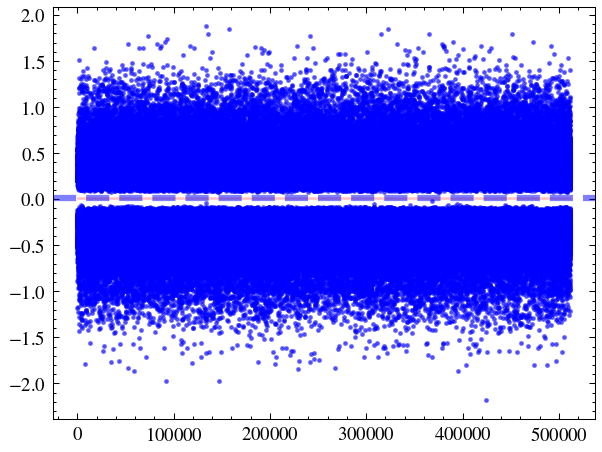

: 

In [ ]:
plt.figure(figsize=(4,3))

# NQS
if True:
    exp_corr            = psi.compute_observable(functions=sig_x0.jax, return_stats=True, num_samples=2000)
    plt.axhline(np.real(exp_corr.mean), color='blue', linestyle='--', lw=3, alpha=0.5, label='NQS')
    plt.scatter(x=np.arange(len(exp_corr.values)), y=np.real(exp_corr.values), s=2, color='blue', alpha=0.5, label='Samples')
    plt.fill_between(
        x               =   np.arange(len(exp_corr.values)),
        y1              =   np.real(exp_corr.mean - 2*exp_corr.error_of_mean),
        y2              =   np.real(exp_corr.mean + 2*exp_corr.error_of_mean),
        color           =   'red',
        alpha           =   0.2,
        label           =   r'Error of the mean ($2\sigma$)',
    )
    
if perf_exact_diag and hamil.eig_vec is not None:
    exp_lanczos     = hamil.eig_vec[:, 0].conj().T @ sig_x0.matvec(hamil.eig_vec[:, 0])
    plt.axhline(np.real(exp_lanczos), color='red', linestyle='--', label='ED Lanczos')
    
plt.xlabel('Sample index')
plt.ylabel(r'$\langle \sigma^x_0 \sigma^z_1 \rangle$')
plt.legend(frameon=True, fontsize=8)
plt.ylim(-0.5, 0.5)
plt.tight_layout()

#### $\sigma^x_0 \sigma^z_1$ operator

In [ ]:
# evaluate single sig_x0_z1 expectation value
plt.figure(figsize=(4,3))

# NQS
if True:
    exp_corr = psi.compute_observable(functions=sig_x0_z1.jax, return_stats=True)
    plt.axhline(np.real(exp_corr.mean), color='blue', linestyle='--', label='NQS', lw=3, alpha=0.5)
    plt.scatter(x=np.arange(len(exp_corr.values)), y=np.real(exp_corr.values), s=2, color='blue', alpha=0.5, label='Samples')
    plt.fill_between(
        x               =   np.arange(len(exp_corr.values)),
        y1              =   np.real(exp_corr.mean - 2*exp_corr.error_of_mean),
        y2              =   np.real(exp_corr.mean + 2*exp_corr.error_of_mean),
        color           =   'red',
        alpha           =   0.2,
        label           =   r'Error of the mean ($2\sigma$)',
    )
    
if perf_exact_diag and hamil.eig_vec is not None:
    exp_lanczos     = hamil.eig_vec[:, 0].conj().T @ sig_x0_z1.matvec(hamil.eig_vec[:, 0])
    plt.axhline(np.real(exp_lanczos), color='red', linestyle='--', label='ED Lanczos')
    
plt.xlabel('Sample index')
plt.ylabel(r'$\langle \sigma^x_0 \sigma^z_1 \rangle$')
plt.ylim(-0.5, 0.5)
plt.legend(frameon=True, fontsize=8)
plt.tight_layout()

## 2. Impurity Studies

Systematic single- and two-impurity experiments on the Kitaev honeycomb model.
Following the J₁-J₂ / impurity paradigm, we compute:

**Single impurity:** $\Delta E$, local magnetization $\langle S^z_i \rangle$, spin texture, $\langle \mathbf{S}_i \cdot \mathbf{S}_j \rangle$, bond-energy texture

**Two impurities:** Interaction potential $V(R)$, effective exchange $J_\text{eff}$, sublattice dependence (A-A vs A-B), $\langle \mathbf{S}_1 \cdot \mathbf{S}_2 \rangle$

**Bulk observables:** Correlation functions, plaquette operators & correlations, entanglement entropy across bipartition cuts

### a) Define impurity scenarios

**Spherical coordinates:** `(site, theta, phi, strength)` → $\mathbf{S} = (\sin\theta\cos\phi,\;\sin\theta\sin\phi,\;\cos\theta) \times \text{strength}$

| $\theta$ | $\phi$ | Direction |
|-----------|--------|-----------|
| $0$       | $0$    | $+z$     |
| $\pi$     | $0$    | $-z$     |
| $\pi/2$   | $0$    | $+x$     |
| $\pi/2$   | $\pi/2$| $+y$     |

In [ ]:
# -----------------------------------------------------------------------
# Single-impurity scenarios
# -----------------------------------------------------------------------
# We place a single magnetic impurity at representative sites:
#   - site 0 (sublattice A, corner)
#   - center_site (sublattice A or B, bulk)
#   - site 1 (sublattice B, nearest neighbor to 0)
# with z-polarized (up/down) and x-polarized directions.

center = p_cfg.center_site
print(f"Lattice: {p_cfg.lx}×{p_cfg.ly} honeycomb ({p_cfg.bc.upper()}), Ns={lattice.ns}")
print(f"Center site: {center}")

single_impurity_scenarios = {
    # label: impurities list
    "clean":            [],
    # --- z-polarized at various sites ---
    "site0_z_up":       [(0,      0.0,     0.0,  1.0)],    # site 0 (sublattice A), +z
    "site0_z_down":     [(0,      np.pi,   0.0,  1.0)],    # site 0 (sublattice A), -z
    "site1_z_up":       [(1,      0.0,     0.0,  1.0)],    # site 1 (sublattice B), +z
    "site1_z_down":     [(1,      np.pi,   0.0,  1.0)],    # site 1 (sublattice B), -z
    "center_z_up":      [(center, 0.0,     0.0,  1.0)],    # center (bulk), +z
    "center_z_down":    [(center, np.pi,   0.0,  1.0)],    # center (bulk), -z
    # --- x-polarized at center (tests anisotropy response) ---
    "center_x":         [(center, np.pi/2, 0.0,  1.0)],    # center, +x
    # --- varying strength at center (weak → strong) ---
    "center_z_weak":    [(center, 0.0,     0.0,  0.1)],    # weak impurity
    "center_z_strong":  [(center, 0.0,     0.0,  5.0)],    # strong impurity
}

print(f"\nSingle-impurity scenarios ({len(single_impurity_scenarios)}):")
for name, imps in single_impurity_scenarios.items():
    if imps:
        sites = [imp[0] for imp in imps]
        dirs  = []
        for imp in imps:
            sx = np.sin(imp[1]) * np.cos(imp[2])
            sy = np.sin(imp[1]) * np.sin(imp[2])
            sz = np.cos(imp[1])
            dirs.append(f"({sx:.2f},{sy:.2f},{sz:.2f})×{imp[3]}")
        print(f"  {name:20s}: sites={sites}, S={dirs}")
    else:
        print(f"  {name:20s}: (clean reference)")

In [ ]:
# -----------------------------------------------------------------------
# Two-impurity scenarios
# -----------------------------------------------------------------------
# For V(R)=E(R)-2*E_single+E_clean and effective exchange J_eff,
# we need pairs at varying distances on both sublattice combinations:
#   A-A (same sublattice), A-B (different sublattice)
# All z-polarized for simplicity; parallel (↑↑) and antiparallel (↑↓).

from impurity_solver import compute_impurity_distances

# Pick representative site pairs at increasing distances
# Sublattice A sites: even indices (0, 2, 4, ...)
# Sublattice B sites: odd indices  (1, 3, 5, ...)
sublattice_A = sorted([i for i in range(lattice.ns) if i % 2 == 0])
sublattice_B = sorted([i for i in range(lattice.ns) if i % 2 == 1])
print(f"Sublattice A ({len(sublattice_A)} sites): {sublattice_A}")
print(f"Sublattice B ({len(sublattice_B)} sites): {sublattice_B}")

# Compute all pairwise distances from site 0 (sublattice A)
positions = np.array([lattice.rvectors[i] for i in range(lattice.ns)])
ref_pos   = positions[0]
dists_from_0 = np.array([np.linalg.norm(positions[j] - ref_pos) for j in range(lattice.ns)])

# Select A-A pairs (site 0 + another A site) at distinct distances
aa_candidates = [(0, s, dists_from_0[s]) for s in sublattice_A if s != 0]
aa_candidates.sort(key=lambda x: x[2])
# Remove duplicate distances (keep first)
aa_pairs = []
seen_dists = set()
for s1, s2, d in aa_candidates:
    d_round = round(d, 4)
    if d_round not in seen_dists:
        aa_pairs.append((s1, s2, d))
        seen_dists.add(d_round)

# Select A-B pairs (site 0 + B site)
ab_candidates = [(0, s, dists_from_0[s]) for s in sublattice_B]
ab_candidates.sort(key=lambda x: x[2])
ab_pairs = []
seen_dists_ab = set()
for s1, s2, d in ab_candidates:
    d_round = round(d, 4)
    if d_round not in seen_dists_ab:
        ab_pairs.append((s1, s2, d))
        seen_dists_ab.add(d_round)

print(f"\nA-A pairs (from site 0): {[(s2, f'd={d:.3f}') for _, s2, d in aa_pairs]}")
print(f"A-B pairs (from site 0): {[(s2, f'd={d:.3f}') for _, s2, d in ab_pairs]}")

# Build two-impurity scenarios
two_impurity_scenarios = {}
for s1, s2, d in aa_pairs:
    # Parallel (both +z)
    two_impurity_scenarios[f"AA_par_d{d:.2f}_s{s1}s{s2}"] = [
        (s1, 0.0,    0.0, 1.0),  # +z
        (s2, 0.0,    0.0, 1.0),  # +z
    ]
    # Antiparallel (+z, -z)
    two_impurity_scenarios[f"AA_anti_d{d:.2f}_s{s1}s{s2}"] = [
        (s1, 0.0,    0.0, 1.0),  # +z
        (s2, np.pi,  0.0, 1.0),  # -z
    ]

for s1, s2, d in ab_pairs:
    two_impurity_scenarios[f"AB_par_d{d:.2f}_s{s1}s{s2}"] = [
        (s1, 0.0,    0.0, 1.0),
        (s2, 0.0,    0.0, 1.0),
    ]
    two_impurity_scenarios[f"AB_anti_d{d:.2f}_s{s1}s{s2}"] = [
        (s1, 0.0,    0.0, 1.0),
        (s2, np.pi,  0.0, 1.0),
    ]

print(f"\nTwo-impurity scenarios ({len(two_impurity_scenarios)}):")
for name, imps in two_impurity_scenarios.items():
    sites = [imp[0] for imp in imps]
    dists = compute_impurity_distances(lattice, imps)
    pair_dist = dists[0, sites[1]] if len(sites) > 1 else 0
    dirs = ["↑" if imp[1] == 0 else "↓" for imp in imps]
    print(f"  {name:35s}: sites={sites}, spins={''.join(dirs)}, d={pair_dist:.3f}")

### b) Run impurity scenarios

For each scenario:
1. Build Hamiltonian with impurities via `make_hamiltonian(PhysicsConfig(impurities=...))`
2. Fine-tune from the clean-model weights (warm start)
3. Compute ED observables: correlations, magnetization, plaquettes, entropy
4. Compute NQS observables: correlations, magnetization, plaquettes, entropy
5. Store results for post-processing (ΔE, V(R), J_eff, etc.)

In [ ]:
# -----------------------------------------------------------------------
# Impurity training loop
# -----------------------------------------------------------------------
# NOTE: This cell can take a long time to run. Select which scenario set
# to run by toggling the flags below.
# -----------------------------------------------------------------------

from impurity_solver import compute_ed_observables, compute_nqs_observables
from pathlib import Path
import copy, time

RUN_SINGLE_IMPURITY = True      # Toggle single-impurity scenarios
RUN_TWO_IMPURITY    = False     # Toggle two-impurity scenarios (more expensive)
FINE_TUNE_EPOCHS    = 500       # Epochs for fine-tuning from clean weights
ED_FOR_IMPURITY     = True      # Run ED for impurity Hamiltonians (disable for large Ns)

# Combine selected scenarios
scenarios_to_run = {}
if RUN_SINGLE_IMPURITY:
    scenarios_to_run.update(single_impurity_scenarios)
if RUN_TWO_IMPURITY:
    scenarios_to_run.update(two_impurity_scenarios)

# Store clean-model reference energy
E_clean = float(ed_energy) if perf_exact_diag else float(last_energy)
print(f"Clean ground-state energy: E_clean = {E_clean:.6f}")
print(f"Scenarios to run: {len(scenarios_to_run)}")

# Results storage
impurity_results = {}
out_base = Path(save_path) / "impurity_study"

for scenario_name, imps in scenarios_to_run.items():
    print(f"\n{'='*60}")
    print(f"Scenario: {scenario_name}")
    print(f"{'='*60}")
    t0 = time.time()

    # --- 1. Build impurity Hamiltonian ---
    imp_pcfg = PhysicsConfig(
        model_type   = p_cfg.model_type,
        lattice_type = p_cfg.lattice_type,
        lx           = p_cfg.lx,
        ly           = p_cfg.ly,
        bc           = p_cfg.bc,
        kxy          = p_cfg.kxy,
        kz           = p_cfg.kz,
        gamma_xy     = p_cfg.gamma_xy,
        gamma_z      = p_cfg.gamma_z,
        hx           = p_cfg.hx,
        hy           = p_cfg.hy,
        impurities   = imps if imps else None,
    )
    imp_hamil, imp_hilbert, imp_lattice = make_hamiltonian(
        imp_pcfg, dtype=dtype,
        tx=0 if not imps else None,
        ty=0 if not imps else None,
        verbose=False,
    )

    result = {"scenario": scenario_name, "impurities": imps}

    # --- 2. ED (if enabled and feasible) ---
    if ED_FOR_IMPURITY and imp_pcfg.num_sites <= s_cfg.max_ed_size:
        try:
            imp_hamil.hamiltonian()
            imp_hamil.diag(solver='lanczos', k=min(6, s_cfg.n_ed_states))
            result["ed_energy"] = float(imp_hamil.eig_val[0])
            result["delta_E_ed"] = result["ed_energy"] - E_clean
            print(f"  ED: E₀ = {result['ed_energy']:.6f}, ΔE = {result['delta_E_ed']:.6f}")
        except Exception as e:
            print(f"  ED failed: {e}")
            result["ed_energy"] = None

    # --- 3. Fine-tune NQS from clean weights ---
    imp_scfg = SolverConfig(
        ansatz          = s_cfg.ansatz,
        sampler         = s_cfg.sampler,
        n_chains        = s_cfg.n_chains,
        n_samples       = s_cfg.n_samples,
        epochs_pre      = FINE_TUNE_EPOCHS,
        epochs_fine     = 0,
        lr              = s_cfg.lr * 0.5,  # Lower LR for fine-tuning
        compute_entropy = True,
        entropy_samples = s_cfg.entropy_samples,
        renyi_q_values  = s_cfg.renyi_q_values,
        obs_samples     = s_cfg.obs_samples,
        n_ed_states     = s_cfg.n_ed_states,
    )

    # Create new NQS with same architecture, copy clean weights
    imp_net = make_net(net_type, imp_pcfg, imp_scfg, dtype=dtypenet)
    imp_psi = NQS(imp_hamil, imp_net, dtype=dtypenet)
    # Warm-start: copy parameters from clean model
    try:
        imp_psi.net.params = copy.deepcopy(psi.net.params)
        print(f"  Warm-started from clean model weights")
    except Exception as e:
        print(f"  Could not warm-start: {e}")

    # Train
    imp_psi.train(
        method      = 'sr',
        lr          = imp_scfg.lr,
        epochs      = imp_scfg.epochs_pre,
        n_samples   = imp_scfg.n_samples,
        use_minsr   = use_minsr,
    )
    result["nqs_energy"]    = float(imp_psi.energy)
    result["nqs_energy_std"]= float(imp_psi.energy_std) if hasattr(imp_psi, 'energy_std') else np.nan
    result["delta_E_nqs"]   = result["nqs_energy"] - E_clean
    print(f"  NQS: E₀ = {result['nqs_energy']:.6f}, ΔE = {result['delta_E_nqs']:.6f}")

    # --- 4. Compute observables ---
    out_dir = out_base / scenario_name

    # ED observables (correlations, magnetization, plaquettes, entropy)
    if ED_FOR_IMPURITY and result.get("ed_energy") is not None and imp_hamil.eig_vec is not None:
        try:
            ed_obs = compute_ed_observables(
                imp_hamil, imp_lattice, imp_pcfg, imp_scfg, out_dir, impurities=imps
            )
            result["ed_correlations"]   = ed_obs.get("correlations")
            result["ed_magnetization"]  = ed_obs.get("magnetization")
            result["ed_plaquettes"]     = ed_obs.get("plaquettes")
            result["ed_entropy"]        = ed_obs.get("entropy")
            print(f"  ED observables: correlations, magnetization, plaquettes, entropy ✓")
        except Exception as e:
            print(f"  ED observables failed: {e}")

    # NQS observables
    try:
        nqs_obs = compute_nqs_observables(
            imp_psi, imp_lattice, imp_pcfg, imp_scfg, out_dir,
            history=None, impurities=imps
        )
        result["nqs_correlations"]  = nqs_obs.get("correlations")
        result["nqs_magnetization"] = nqs_obs.get("magnetization")
        result["nqs_plaquettes"]    = nqs_obs.get("plaquettes")
        result["nqs_entropy"]       = nqs_obs.get("entropy")
        print(f"  NQS observables: correlations, magnetization, plaquettes, entropy ✓")
    except Exception as e:
        print(f"  NQS observables failed: {e}")

    # Impurity-specific: local magnetization near impurity
    if imps:
        result["impurity_distances"] = compute_impurity_distances(imp_lattice, imps)

    elapsed = time.time() - t0
    result["time_s"] = elapsed
    impurity_results[scenario_name] = result
    print(f"  Completed in {elapsed:.1f}s")

print(f"\n{'='*60}")
print(f"All scenarios complete. Results stored in `impurity_results`.")
print(f"Data saved to {out_base}/")

### c) Post-processing: energy shifts, interaction potential, data summary

Verify that all required data has been generated:
- **Correlation functions** $\langle S^\alpha_i S^\beta_j \rangle$ (ED + NQS)
- **Plaquette operators** and inter-plaquette correlations
- **Entanglement entropy** $S_\text{vN}$, $S_2$, $S_3$ across bipartition cuts
- **Single-impurity:** $\Delta E$, local magnetization texture, bond-energy texture
- **Two-impurity:** $V(R) = E_{12}(R) - 2 E_\text{single} + E_\text{clean}$, sublattice dependence

In [ ]:
# -----------------------------------------------------------------------
# Post-processing: summarize impurity results and verify data completeness
# -----------------------------------------------------------------------

# --- 1. Energy shift summary table ---
print("=" * 80)
print("SINGLE-IMPURITY ENERGY SHIFTS")
print("=" * 80)
print(f"{'Scenario':<22} {'E_ED':>12} {'ΔE_ED':>10} {'E_NQS':>12} {'ΔE_NQS':>10}")
print("-" * 66)
for name, res in impurity_results.items():
    if name.startswith("AA_") or name.startswith("AB_"):
        continue  # skip two-impurity here
    e_ed  = res.get("ed_energy", np.nan)
    de_ed = res.get("delta_E_ed", np.nan)
    e_nqs = res.get("nqs_energy", np.nan)
    de_nqs= res.get("delta_E_nqs", np.nan)
    print(f"{name:<22} {e_ed:>12.6f} {de_ed:>10.6f} {e_nqs:>12.6f} {de_nqs:>10.6f}")

# --- 2. Two-impurity interaction potential V(R) ---
if any(k.startswith("AA_") or k.startswith("AB_") for k in impurity_results):
    print(f"\n{'='*80}")
    print("TWO-IMPURITY INTERACTION POTENTIAL V(R)")
    print("=" * 80)
    # Get single-impurity reference energy (site 0, +z)
    E_single_ref = impurity_results.get("site0_z_up", {}).get("ed_energy", E_clean)
    print(f"Reference single-impurity energy: {E_single_ref:.6f}")
    print(f"{'Scenario':<36} {'d':>6} {'E_ED':>12} {'V(R)_ED':>10} {'E_NQS':>12} {'V(R)_NQS':>10}")
    print("-" * 88)
    for name, res in impurity_results.items():
        if not (name.startswith("AA_") or name.startswith("AB_")):
            continue
        e_ed  = res.get("ed_energy", np.nan)
        e_nqs = res.get("nqs_energy", np.nan)
        # V(R) = E_pair(R) - 2*E_single + E_clean
        v_ed  = e_ed - 2 * E_single_ref + E_clean if not np.isnan(e_ed) else np.nan
        v_nqs = e_nqs - 2 * E_single_ref + E_clean if not np.isnan(e_nqs) else np.nan
        dists = res.get("impurity_distances")
        d = dists[0, res["impurities"][1][0]] if dists is not None and len(res["impurities"]) > 1 else np.nan
        print(f"{name:<36} {d:>6.3f} {e_ed:>12.6f} {v_ed:>10.6f} {e_nqs:>12.6f} {v_nqs:>10.6f}")

# --- 3. Data completeness check ---
print(f"\n{'='*80}")
print("DATA COMPLETENESS CHECK")
print("=" * 80)
observable_keys = [
    ("ed_correlations",  "Correlation functions (ED)"),
    ("nqs_correlations", "Correlation functions (NQS)"),
    ("ed_magnetization", "Local magnetization (ED)"),
    ("nqs_magnetization","Local magnetization (NQS)"),
    ("ed_plaquettes",    "Plaquette operators (ED)"),
    ("nqs_plaquettes",   "Plaquette operators (NQS)"),
    ("ed_entropy",       "Entanglement entropy (ED)"),
    ("nqs_entropy",      "Entanglement entropy (NQS)"),
    ("impurity_distances","Impurity distances"),
]

for name, res in impurity_results.items():
    print(f"\n  {name}:")
    for key, label in observable_keys:
        has_data = res.get(key) is not None
        status = "✓" if has_data else "✗"
        extra = ""
        if key.endswith("_entropy") and has_data:
            cuts = list(res[key].keys())
            extra = f" ({len(cuts)} cuts: {', '.join(cuts[:4])}{'...' if len(cuts) > 4 else ''})"
        if key == "ed_correlations" and has_data:
            shape = np.array(res[key]).shape if hasattr(res[key], '__len__') else "scalar"
            extra = f" (shape={shape})"
        print(f"    {status} {label}{extra}")

print(f"\n{'='*80}")
print(f"Total scenarios: {len(impurity_results)}")
print(f"Output directory: {out_base}/")
print(f"Each scenario has HDF5 files: ed_observables.h5, nqs_observables.h5")

## 3. Configure the NQS with Autoregressive Sampler

In [ ]:
# AR networks are MUCH harder to train than RBMs:
# 1. Larger hidden layers needed (more parameters)
# 2. Higher learning rate initially 
# 3. More samples for stable gradients
# 4. Phase learning is slow (zero-initialized)

ar_hidden       = (64, 64)      # Larger than default (32, 32)
phase_hidden    = (64, 64)      # Match amplitude network size

psi_ar = NQS(
    logansatz       = 'ar',
    model           = hamil,
    sampler         = 'ARSampler',
    backend         = 'jax',
    hilbert         = hilbert,
    dtype           = dtype,
    # Network architecture
    ar_hidden       = ar_hidden,
    phase_hidden    = phase_hidden,
    # Sampling - AR gives exact samples, but need more for stable SR
    s_numchains     = 1,
    s_numsamples    = 200,      # More samples for SR stability
)

In [ ]:
_, (samples, ansatze), _ = psi_ar.sample()

In [ ]:
samples.shape

In [ ]:
samples[0]

In [ ]:
psi_ar.help('general')

In [ ]:
# AR training tips for FRUSTRATED systems (Kitaev-Gamma):
# 
# KEY INSIGHT: AR networks struggle with frustrated phases because:
# 1. Phase network starts at ZERO - takes a long time to learn non-trivial signs
# 2. Amplitude network dominates early training
# 3. Standard SR can have ill-conditioned covariance matrices

# Moderate hidden layers for 8GB GPU
ar_hidden       = (64, 64)       # Reduced from (128, 128)
phase_hidden    = (64, 64)       # Reduced from (128, 128)

# Reinitialize with memory-efficient network
psi_ar = NQS(
    logansatz       = 'ar',
    model           = hamil,
    sampler         = 'ARSampler',
    backend         = 'jax',
    hilbert         = hilbert,
    dtype           = dtype,
    directory       = "./mcdata/",
    # Network architecture - moderate size
    ar_hidden       = ar_hidden,
    phase_hidden    = phase_hidden,
    # Reduced samples for memory
    s_numchains     = 1,
    s_numsamples    = 200,
)

print(f"AR Network: {psi_ar.num_params} parameters")
print(f"Hidden layers: amplitude={ar_hidden}, phase={phase_hidden}")

In [ ]:
# AR networks need MORE epochs and patience
# The phase network starts from zero and takes time to learn

nepochs_ar          = 1000          # More epochs for AR
perf_exact_diag_ar  = True          # Compare with exact
load_weights_ar     = True          # Try to load existing weights

# Training configuration dictionary
train_config_ar = dict(
    n_epochs            =   nepochs_ar,
    checkpoint_every    =   100,
    reset_stats         =   False,
    # Training settings
    use_pbar            =   True,
    reset_weights       =   False,
    lin_solver          =   'scipy_cg',
    ode_solver          =   'Euler',
    phases              =   'kitaev',
    diag_scheduler      =   'cosine',
    # SR settings
    use_minsr           =   False,           # Try True if memory issues
    use_sr              =   True,
    diag_shift          =   1e-2,            # Start high for AR stability
    # Learning rate - start high for AR
    lr                  =   0.05,
    # Exact predictions for comparison
    exact_predictions   =   hamil.eigenvalues if perf_exact_diag_ar else None,
    exact_method        =   'lanczos' if perf_exact_diag_ar else None,
)

# Optionally perform exact diagonalization BEFORE training (to store in stats)
if perf_exact_diag_ar:
    hamil.build()
    hamil.diagonalize(method='lanczos', k=50, store_basis=True, verbose=False, use_scipy=True, tol=1e-6, maxiter=200)
    logger.info(f"Exact ground state energy: {hamil.eigenvalues[0]:.6f}", lvl=1)
    logger.info(f"Lowest 10 energies: {hamil.eigenvalues[:10]}", lvl=2)
    # Update config with exact predictions
    train_config_ar['exact_predictions'] = hamil.eigenvalues

# Train or load weights
if not load_weights_ar:
    stats_ar = psi_ar.train(**train_config_ar)
else:
    # Try to load checkpoint if it exists
    try:
        stats_ar = psi_ar.trainer.load_checkpoint(nepochs_ar)
        if stats_ar.has_exact:
            logger.info(f"Loaded exact predictions from checkpoint: ground state = {stats_ar.exact_gs:.6f}", color='red')
            perf_exact_diag_ar = False  # Skip re-diagonalization
        logger.info(f"Loaded checkpoint at epoch {nepochs_ar}", color='green')
    except Exception as e:
        logger.warning(f"Could not load checkpoint: {e}. Training from scratch...")
        load_weights_ar = False
        stats_ar = psi_ar.train(**train_config_ar)

In [ ]:
import matplotlib.pyplot as plt

fig, ax                 = plt.subplots(1, 3, figsize=(12,4), sharex=True)

# Get exact energies from stats (if available) or Hamiltonian
if stats_ar.has_exact:
    ed_energy_ar           = stats_ar.exact_gs                 / hilbert.ns
    ed_excited_energies_ar = stats_ar.exact_predictions[1:11]  / hilbert.ns if len(stats_ar.exact_predictions) > 1 else np.array([])
elif hamil.eigenvalues is not None:
    ed_energy_ar           = hamil.eigenvalues[0]              / hilbert.ns
    ed_excited_energies_ar = hamil.eigenvalues[1:11]           / hilbert.ns
else:
    ed_energy_ar           = None
    ed_excited_energies_ar = np.array([])

history_ar              = np.array(stats_ar.history)        / hilbert.ns
history_std_ar          = np.array(stats_ar.history_std)    / hilbert.ns
last_energies_ar        = history_ar[-30:] 
last_energy_ar          = np.mean(last_energies_ar)
last_energy_std_ar      = np.std(last_energies_ar)
print(f"Final energy estimate: {last_energy_ar:.6f} ± {last_energy_std_ar:.6f}")

ax[0].plot(history_ar)
ax[0].fill_between(
    x               =   np.arange(len(history_ar)),
    y1              =   history_ar - history_std_ar,
    y2              =   history_ar + history_std_ar,
    color           =   'blue',
    alpha           =   0.3,
)
ax[0].axhline(last_energy_ar, color='red', label=f'Final energy: {last_energy_ar:.6f}', linestyle=':')

# ED reference lines
if ed_energy_ar is not None:
    ax[0].axhline(ed_energy_ar, color='green', label=f'True energy: {ed_energy_ar:.6f}', linestyle='--')
    for i, ene in enumerate(ed_excited_energies_ar):
        ax[0].axhline(ene, color=f'C{i+2}', linestyle='--', alpha=0.3, linewidth=0.8)

# Labels
ax[0].set_xlabel('$N$')
ax[0].set_ylabel('Energy per site')
ax[0].legend()

# -----------------------------------------------------------------------
#! Regularizations

ax[1].plot(stats_ar.lr_history,         label=r'Learning Rate $\eta$')
if len(stats_ar.diag_history):
    ax[1].plot(stats_ar.diag_history,   label=r'Diagonal Shift $\sigma$')
if len(stats_ar.reg_history):
    ax[1].plot(stats_ar.reg_history,    label=r'Regularization $\lambda$')

ax[1].set_xlabel('$N$')
ax[1].set_ylabel('Regularization parameters')
ax[1].legend()
ax[1].set_yscale('log')

# -----------------------------------------------------------------------
#! Timing
# -----------------------------------------------------------------------

ax[2].plot(np.array(stats_ar.timings.total) / len(stats_ar.history), label=r'$\sum t_i \ / \ N$')
ax[2].set_xlabel(r'$N$')
ax[2].set_yscale('log')
ax[2].legend()

ax[2].plot(stats_ar.timings.sample,  color='red',    ls='--')
ax[2].plot(stats_ar.timings.step,    color='green',  ls=':')
ax[2].plot(stats_ar.timings.update,  color='blue',   ls='-.')
ax[2].set_yscale('log')
ax[2].set_ylabel('t (s)')

plt.tight_layout()